# Détection de fraude bancaire
### Big Data Mining M2 SISE : Pauline Lainé - Khanh Hoàng Lê

## 1. Introduction

Lorsqu'un client paye par chèque, il se peut que celui-ci ne paye jamais son panier, nous sommes alors dans le cas d'une fraude. Deux raisons peuvent être dû à une fraude. 

Le premier cas, c'est lorsque nous sommes dans le cas d'un chèque dit impayé, ce cas de figure apparait lorsque la personne ne possède pas le solde sur son compte en banque. L'autre cas de figure c'est lorsque nous avons à faire à un faux chèque. Un faux chèque peut se caractériser par une fausse identité ou lorsque le CMC7 est incorrect. Le CMC7 est une série de Caractères Magnétiques Codés à 7 bâtonnets situé en bas d'un chèque.

Sur une période de 10 mois, ces fraudes se compte au nombre de 20 000 soit 0.6% des transactions réalisées, réprésentant un chiffre d'affaires de 2 millions d'euros qui équivaut à 1.1% du chiffre d'affaires total de l'enseigne. C'est un chiffre d'affaires perdu non négligable. 

Notre étude va alors se porter sur la détection des fraudes par chèque dans un contexte déséquilibré.

## 2. Les données

Les données que nous allons utiliser provienne d'une enseigne de grande distribustion et d'organismes bancaires tels que la FNCI et la Banque de France. Nous avons une ligne par transaction sur la période du 21/03/2016 au 19/10/2016 soit une période de 7 mois. Chaque transaction est décrite par les 23 variables suivantes : 

- ZIBZIN : identifiant bancaire relatif à la personne
- IDAvisAutorisAtionCheque : identifiant de la transaction en cours
- Montant : montant de la transaction
- DateTransaction : date de la transaction
- CodeDecision : il s’agit d’une variable qui peut prendre ici 4 valeurs
    - 0 : la transaction a été acceptée par le magasin
    - 1 : la transaction et donc le client fait partie d’une liste blanche (bons payeurs). Aucun dans cette base de données
    - 2 : le client fait d’une partie d’une liste noire, son historique indique c'est un mauvais payeur (des impayés en cours ou des incidents bancaires en cours), sa transaction est alors automatiquement refusée
    - 3 : client ayant était arrêté par le système par le passé pour une raison plus ou moins fondée
- VérifianceCPT1 : nombre de transactions effectuées par le même identifiant bancaire au cours du même jour
- VérifianceCPT2 : nombre de transactions effectuées par le même identifiant bancaire au cours des trois derniers jours
- VérifianceCPT3 : nombre de transactions effectuées par le même identifiant bancaire au cours des sept derniers jours
- D2CB : durée de connaissance du client (par son identifiant bancaire), en jours. Pour des contraintes légales, cette durée de connaissance ne peut excéder deux ans
- ScoringFP1 : score d’anormalité du panier relatif à une première famille de produits (ex : denrées alimentaires)
- ScoringFP2 : score d’anormalité du panier relatif à une deuxième famille de produits(ex : électroniques)
- ScoringFP3 : score d’anormalité du panier relatif à une troisième famille de produits (ex : autres)
- TauxImpNb_RB : taux impayés enregistrés selon la région où a lieu la transaction
- TauxImpNB_CPM : taux d’impayés relatif au magasin où a lieu la transaction
- EcartNumCheq : différence entre les numéros de chèques
- NbrMagasin3J : nombre de magasins différents fréquentés les 3 derniers jours
- DiffDateTr1 : écart (en jours) à la précédente transaction
- DiffDateTr2 : écart (en jours) à l’avant dernière transaction
- DiffDateTr3 : écart (en jours) à l’antépénultième transaction
-  CA3TRetMtt : montant des dernières transactions + montant de la transaction en cours
- CA3TR : montant des trois dernières transactions
- Heure : heure de la transaction
- FlagImpaye : acception (0) ou refus de la transaction (1)

Cette dernière variable "FlagImpaye" est celle que nous cherchons à prédire. La classe 0 correspondant aux transactions normales et acceptées et la classe 1 correspond aux fraudes, les transactions qui sont refusées.

Voyons à présent de plus près à quoi ressemble nos données.

#### Importation des librairies 

In [1]:
import numpy as np
import pandas as pd
import missingno as mn
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from time import time
import seaborn as sns
import imblearn
print(imblearn.__version__)

0.7.0


### 2.1. Importation du jeu de données 

In [2]:
import os
os.chdir("D:/OneDrive/Documents/COURS/M2 SISE/Big Data Mining/Projet")
df = pd.read_csv("dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')
#df =pd.read_csv("/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')

In [26]:
df.head()

,ZIBZIN,IDAvisAutorisAtionCheque,MontAnt,DAteTrAnsAction,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
0,A034010041908012010710730,71051532,40.17,2016-03-21 07:47:38,0,1,1,1,535,0.0,...,21.834061,0,1,4.0,4.0,4.0,40.17,0.0,28058,0
1,A035010041908006493331734,71051533,20.00,2016-03-21 08:04:57,0,0,0,0,358,0.0,...,12.586532,0,1,4.0,4.0,4.0,20.00,0.0,29097,0
2,A013010003908005150136747,71051534,35.00,2016-03-21 08:06:45,0,0,0,0,199,0.0,...,39.274924,0,1,4.0,4.0,4.0,35.00,0.0,29205,0
3,A013010041908025639221029,71051536,20.00,2016-03-21 08:11:38,0,0,0,0,38,0.0,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29498,0
4,A013010003908005556100283,71051538,20.00,2016-03-21 08:17:11,0,0,0,0,26,0.0,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29831,0


In [27]:
print(np.shape(df))
print(df.info())

(2231369, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisAtionCheque  int64  
 2   MontAnt                   float64
 3   DAteTrAnsAction           object 
 4   CodeDecision              int64  
 5   VerifiAnceCPT1            int64  
 6   VerifiAnceCPT2            int64  
 7   VerifiAnceCPT3            int64  
 8   D2CB                      int64  
 9   ScoringFP1                float64
 10  ScoringFP2                float64
 11  ScoringFP3                float64
 12  TAuxImpNb_RB              float64
 13  TAuxImpNB_CPM             float64
 14  EcArtNumCheq              int64  
 15  NbrMAgAsin3J              int64  
 16  DiffDAteTr1               float64
 17  DiffDAteTr2               float64
 18  DiffDAteTr3               float64
 19  CA3TRetMtt                float64
 20  CA3TR     

Nous avons une base de données de plus de 2 millions de transactions (2 231 369) caractérisé par 23 variables. La plus part sont quantitatives de type "int64" et "float64". Deux variables sont de type qualitative : l'indentifiant de la personne (ZIBZIN) et la date de la transaction (DAteTrAnsAction).

### 2.2. Valeurs manquantes

Avant de faire des analyses sur nos données. Nous allons dans un premier vérifier si nous avons des valeurs manquantes dans notre jeu de données.  

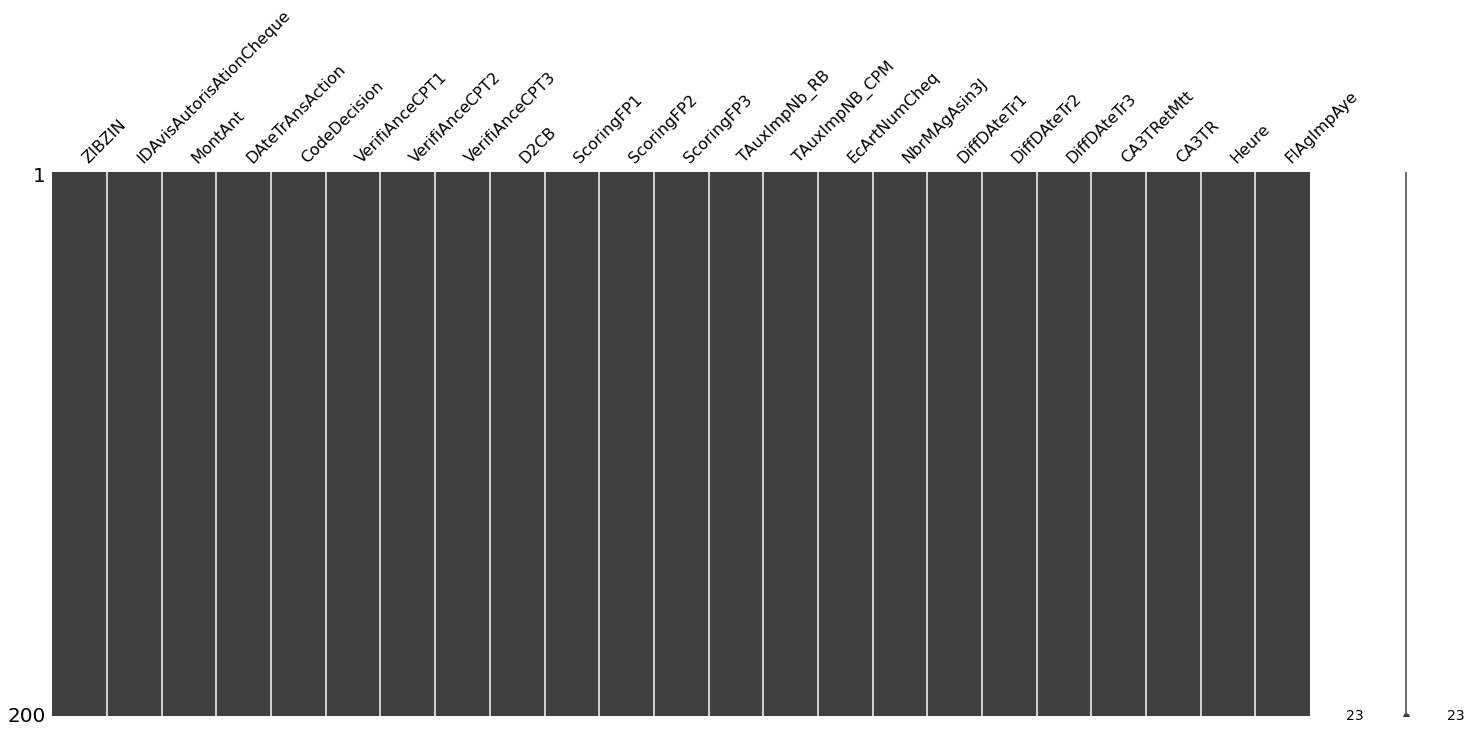

In [6]:
# Matrice des valeurs nulles
mn.matrix(df)

In [29]:
#Nombre de valeurs nulles par variable
print(df.isnull().sum())

ZIBZIN                      0
IDAvisAutorisAtionCheque    0
MontAnt                     0
DAteTrAnsAction             0
CodeDecision                0
VerifiAnceCPT1              0
VerifiAnceCPT2              0
VerifiAnceCPT3              0
D2CB                        0
ScoringFP1                  0
ScoringFP2                  0
ScoringFP3                  0
TAuxImpNb_RB                0
TAuxImpNB_CPM               0
EcArtNumCheq                0
NbrMAgAsin3J                0
DiffDAteTr1                 0
DiffDAteTr2                 0
DiffDAteTr3                 0
CA3TRetMtt                  0
CA3TR                       0
Heure                       0
FlAgImpAye                  0
dtype: int64


Notre jeu de données comporte aucune valeur nulle. Nous allons maintenant pouvoir faire quelques analyses sur nos données.

### 2.3. Analyse univarié

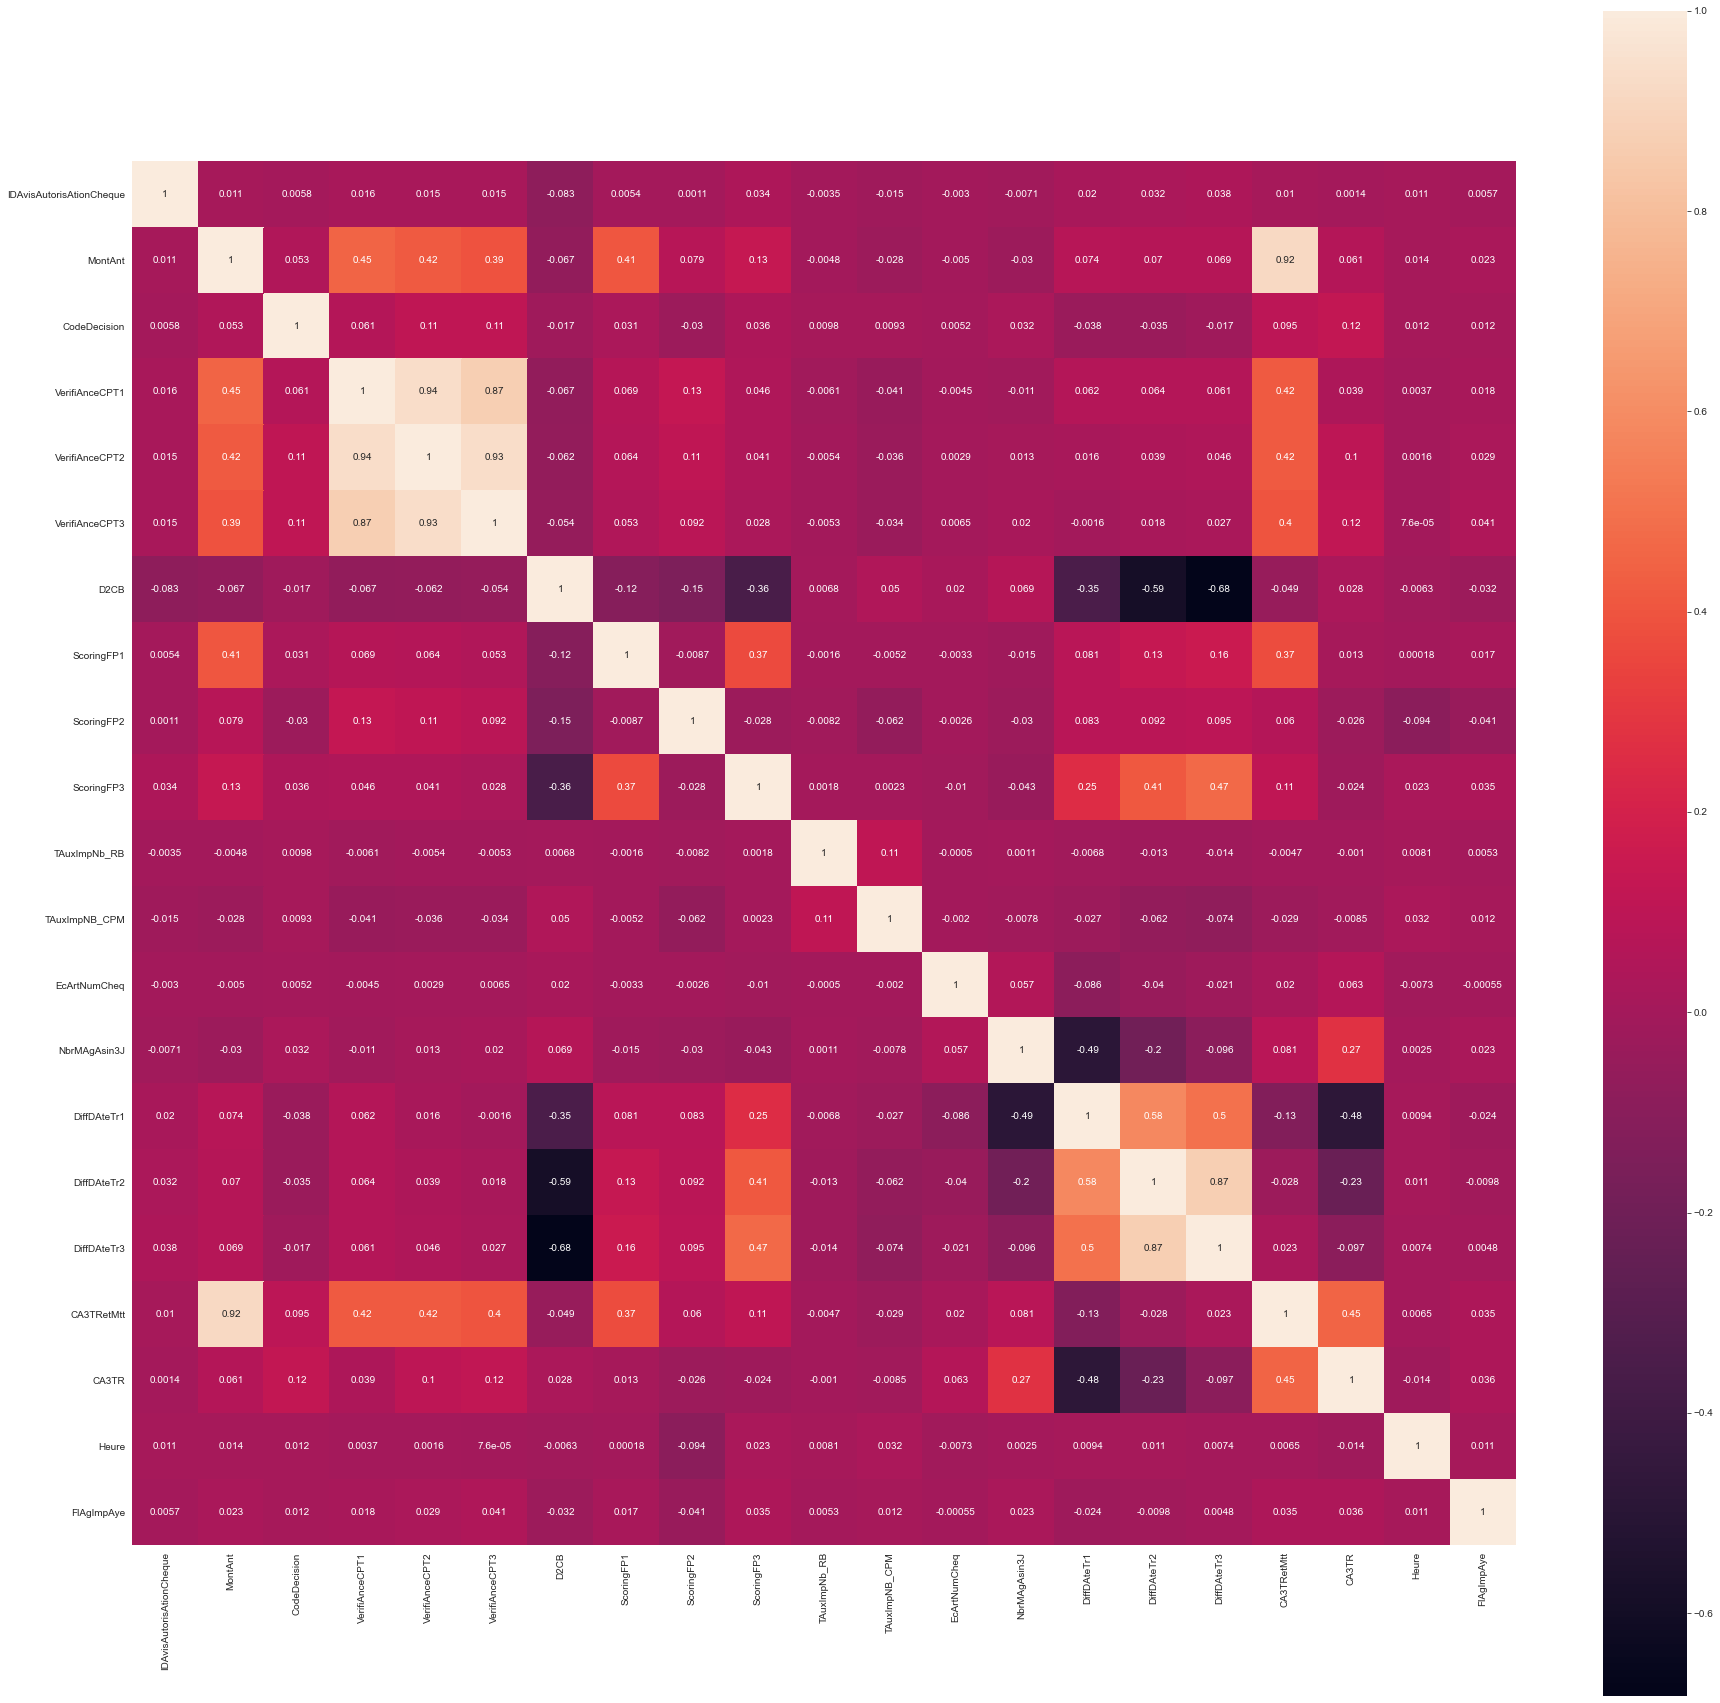

In [28]:
from matplotlib import pyplot
import seaborn as sns
#Matrice de corrélation
sns.set_style("darkgrid")
pyplot.figure(figsize=(31, 31))
sns.heatmap(df.corr(), square=True, annot=True)

In [29]:
df.describe()

,IDAvisAutorisAtionCheque,MontAnt,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
count,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,...,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06
mean,7.356762e+07,5.991771e+01,1.288043e-02,3.991402e-01,4.296752e-01,4.816980e-01,2.477938e+02,3.100542e+00,6.882686e-01,1.769416e-01,...,3.256122e+01,6.724334e+03,1.034200e+00,3.947808e+00,4.234163e+00,4.266234e+00,6.683475e+01,6.917041e+00,5.347306e+04,2.804108e-03
std,1.458268e+06,7.980922e+01,1.682062e-01,5.250070e-01,6.056457e-01,7.339127e-01,2.131088e+02,3.047480e+01,9.336748e+00,5.662696e-01,...,3.475789e+01,1.742520e+05,1.862585e-01,1.078915e+00,5.510923e-01,4.643674e-01,8.929606e+01,3.550385e+01,1.200173e+04,5.287955e-02
min,7.105153e+07,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-4.969986e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.745370e-04,1.365741e-03,1.000000e-02,0.000000e+00,1.336000e+03,0.000000e+00
25%,7.232987e+07,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.874265e-03,-2.869431e+00,1.179973e-03,...,1.390821e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,2.792000e+01,0.000000e+00,4.248500e+04,0.000000e+00
50%,7.353719e+07,4.235000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.430000e+02,1.543502e-02,0.000000e+00,2.131271e-03,...,2.526529e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.732000e+01,0.000000e+00,5.488200e+04,0.000000e+00
75%,7.480167e+07,7.205000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.680000e+02,1.370299e-01,5.289664e+00,1.533859e-02,...,3.927492e+01,0.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,8.130000e+01,0.000000e+00,6.390700e+04,0.000000e+00
max,7.619241e+07,1.698534e+04,3.000000e+00,1.500000e+01,4.000000e+01,4.000000e+01,5.510000e+02,1.680000e+04,4.702998e+01,1.839140e+01,...,7.142857e+02,9.993474e+06,1.000000e+01,5.000000e+00,5.000000e+00,5.000000e+00,1.698534e+04,1.060000e+04,8.256400e+04,1.000000e+00


L'ordre de grandeur des variables varie enormement, il faudra standardiser les données pour nos prédictions. 
On peut voir que le montant moyen d'une transaction est proche de 60€. La plus petite transaction est inférieur à 1€ et la transaction la plus élevé est d'environ 17K€. On voit donc un écart entre c'est deux valeurs. La dispersion de cette variable est élevé. Regardons la distribution de cette variable.

[Text(0, 0.5, 'Distribution')]

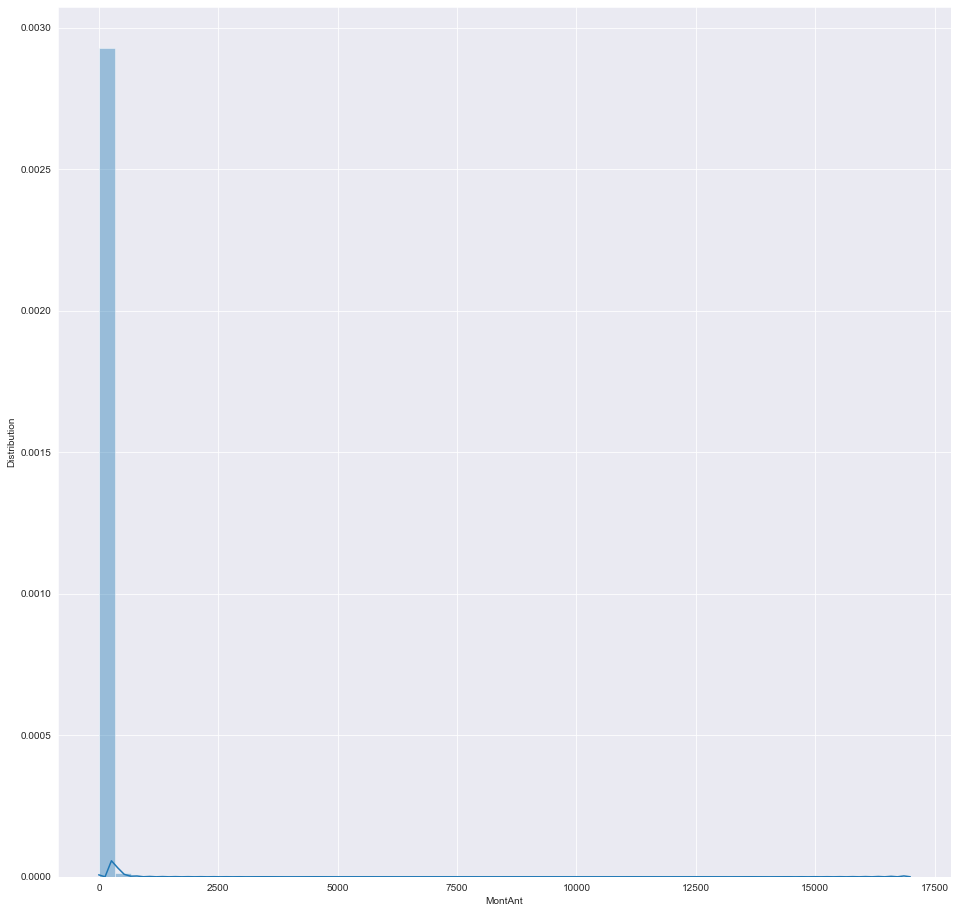

In [30]:
#Distribution de la variable Montant
plt.figure(figsize=(16, 16))
ax = sns.distplot(df["MontAnt"])
ax.set(ylabel="Distribution")  

Quand on regarde la distribution du montant des transactions on voit que la plus part des transactions sont inférieur à 500€. On a très peu de transactions avec une montant très élevé. 
Regardons à présent les deux variables quantitatives discrètes "FlAgImpAye" et "CodeDecision".

In [20]:
#Répartion de la variable CodeDecision
pd.value_counts(df['CodeDecision'])

0    2218002
2      11360
3       2007
Name: CodeDecision, dtype: int64

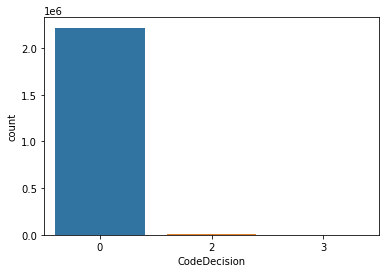

In [28]:
#Barplot
ax = sns.countplot(x="CodeDecision", data=df)

In [18]:
#Répartion de la variable cible FlAgImpAye
#print(pd.value_counts(df['FlAgImpAye']))
print(pd.value_counts(df['FlAgImpAye'])/len(df)) 

0    2225112
1       6257
Name: FlAgImpAye, dtype: int64
0    0.997196
1    0.002804
Name: FlAgImpAye, dtype: float64


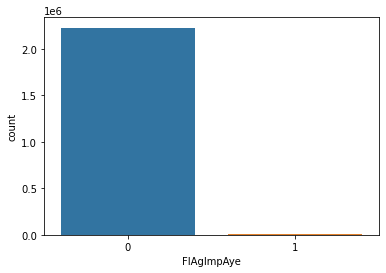

In [13]:
#Barplot
ax = sns.countplot(x="FlAgImpAye", data=df)

On peut donc voir que notre base de données est composé en majorité de transaction qui ont été acepté par l'enseigne.

De plus pour notre variable cible, on voit que la classe 1 dite "frauduleuse" est extremement petite par rapport que la classe normale. Elle représente 0.28% soit plus de 99% de nos données sont de la classe normale. Notre environnement est extrêmement déséquilibré. Nos prédictions seront faussées et risque de prédire tout le temps la classe majoritaire. Pour palier à ça on va donc procéder à un oversampling pour équilibré nos classes sans perdre des informations importantes sur les classes.

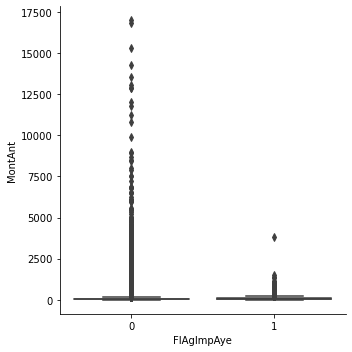

In [26]:
#Relation entre la classe de la transaction et le montant
sns.catplot(x="FlAgImpAye", y="MontAnt", kind="box", data=df)

On voit que les transactions les plus élevées sont des transactions qui ne sont pas frauduleuses.

## 3. Création des echantillons

L'objectif ici est de creer notre base d'apprentissage et de test en fonction de la date. 
- Notre base d'apprentissage comprendra les transactions ayant eu lieu entre le "2016-03-21" et le "2016-09-19" 
- Notre base de Test les transactions ayant eu lieu entre le "2016-09-20" et le "2016-10-19".


In [3]:
#Transformation de la date au format date
df['DAteTrAnsAction'] = pd.to_datetime(df['DAteTrAnsAction'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 23 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ZIBZIN                    object        
 1   IDAvisAutorisAtionCheque  int64         
 2   MontAnt                   float64       
 3   DAteTrAnsAction           datetime64[ns]
 4   CodeDecision              int64         
 5   VerifiAnceCPT1            int64         
 6   VerifiAnceCPT2            int64         
 7   VerifiAnceCPT3            int64         
 8   D2CB                      int64         
 9   ScoringFP1                float64       
 10  ScoringFP2                float64       
 11  ScoringFP3                float64       
 12  TAuxImpNb_RB              float64       
 13  TAuxImpNB_CPM             float64       
 14  EcArtNumCheq              int64         
 15  NbrMAgAsin3J              int64         
 16  DiffDAteTr1               float64       
 17  DiffDAte

In [4]:
#Extraction du mois
df['Month']=df['DAteTrAnsAction'].dt.month
a=pd.value_counts(df['Month'])
#Les mois present
print(df['Month'].unique())

[ 3  4  5  6  7  8  9 10]


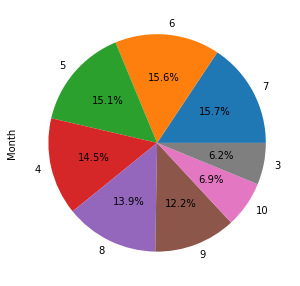

In [5]:
#Répartion par mois
plot = a.plot.pie(y='Month', figsize=(5, 5),autopct='%1.1f%%')

Donc nous avons 8 mois en total,le premier et le dernier et celui qui a le moins activité.

### 3.1. Ensembles d'apprentissage et de test

In [6]:
Apprenti = df.loc[df['DAteTrAnsAction'] < '2016-09-20'] 
Test = df.loc[df['DAteTrAnsAction'] >= '2016-09-20'] 
#print(Apprenti['DAteTrAnsAction'].unique())
#print(Test['DAteTrAnsAction'].unique())

On créer notre ensemble de variable explicatives. On va enlever les variables qui nous semble pas utilise c'est à dire les variables d'identifiants, la variable de date et l'heure. Notre variable cible sera FlAgImpAye.

In [7]:
training_features= Apprenti.drop(Apprenti.columns[[0, 1,3,21,22,23]], axis=1) 
training_target = Apprenti['FlAgImpAye']
#print(X_train.shape)
print(training_features.info())
print(training_target)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967226 entries, 0 to 1967225
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   MontAnt         float64
 1   CodeDecision    int64  
 2   VerifiAnceCPT1  int64  
 3   VerifiAnceCPT2  int64  
 4   VerifiAnceCPT3  int64  
 5   D2CB            int64  
 6   ScoringFP1      float64
 7   ScoringFP2      float64
 8   ScoringFP3      float64
 9   TAuxImpNb_RB    float64
 10  TAuxImpNB_CPM   float64
 11  EcArtNumCheq    int64  
 12  NbrMAgAsin3J    int64  
 13  DiffDAteTr1     float64
 14  DiffDAteTr2     float64
 15  DiffDAteTr3     float64
 16  CA3TRetMtt      float64
 17  CA3TR           float64
dtypes: float64(11), int64(7)
memory usage: 285.2 MB
None
0          0
1          0
2          0
3          0
4          0
          ..
1967221    0
1967222    0
1967223    0
1967224    0
1967225    1
Name: FlAgImpAye, Length: 1967226, dtype: int64


A partir de notre base d'apprentissage on va pouvoir créer notre ensemble d'entrainement et notre ensemble de validation. On a décider de répartir les données en 70% pour l'entrainement et 30% pour le test. 
- Notre base d'entrainement comprend les données du 2016-03-21 au 2016-07-22 
- Notre base de test comprend les données du 2016-07-22 au 2016-09-19

In [8]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = 0.3,
                                                  shuffle=False 
                                                  )

In [9]:
test_features= Test.drop(Apprenti.columns[[0, 1, 3,21,22,23]], axis=1) 
test_target = Test['FlAgImpAye']

## 4. F1 Score 

F1 - Score zef,fkeflka,al,fmlfafa,fe

## 5. SMOTE OverSampling

https://beckernick.github.io/oversampling-modeling/

In [26]:
#training_features, test_features, \
#training_target, test_target, = train_test_split(df.drop(df.columns[[0, 1, 3,21,22]], axis=1),
                                               #df['FlAgImpAye'],
                                               #test_size = .1,
                                               #random_state=12)

In [27]:
#x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  #test_size = .1,
                                                 # random_state=12)

In [10]:
#Réalisation du SMOTE
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [11]:
print(np.shape(x_train_res))
print(pd.value_counts(y_train_res)/len(y_train_res))

(2746922, 18)
1    0.5
0    0.5
Name: FlAgImpAye, dtype: float64


Comme on voit notre variable cible est maintenant équilibré à 50/50. 

## 5. Algorithmes


Les algorithmes que nous allons appliquer sont : 
    - 
    -
    -
    

### 5.1 Random Forest

#### 5.1.1 Avec SMOTE

In [12]:
pipeRFS = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=25, random_state=12))
pipeRFS.fit(x_train_res, y_train_res) 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, random_state=12))])

In [17]:
print(metrics.classification_report(y_val, RDbest.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    588363
           1       0.15      0.11      0.13      1805

    accuracy                           1.00    590168
   macro avg       0.57      0.56      0.56    590168
weighted avg       0.99      1.00      0.99    590168



In [18]:
pipelineDT= make_pipeline(StandardScaler(), RandomForestClassifier())
sorted(pipelineDT.get_params().keys())

['memory',
 'randomforestclassifier',
 'randomforestclassifier__bootstrap',
 'randomforestclassifier__ccp_alpha',
 'randomforestclassifier__class_weight',
 'randomforestclassifier__criterion',
 'randomforestclassifier__max_depth',
 'randomforestclassifier__max_features',
 'randomforestclassifier__max_leaf_nodes',
 'randomforestclassifier__max_samples',
 'randomforestclassifier__min_impurity_decrease',
 'randomforestclassifier__min_impurity_split',
 'randomforestclassifier__min_samples_leaf',
 'randomforestclassifier__min_samples_split',
 'randomforestclassifier__min_weight_fraction_leaf',
 'randomforestclassifier__n_estimators',
 'randomforestclassifier__n_jobs',
 'randomforestclassifier__oob_score',
 'randomforestclassifier__random_state',
 'randomforestclassifier__verbose',
 'randomforestclassifier__warm_start',
 'standardscaler',
 'standardscaler__copy',
 'standardscaler__with_mean',
 'standardscaler__with_std',
 'steps',
 'verbose']

In [19]:
rf_param_grid = {"randomforestclassifier__bootstrap": [True,False],
              "randomforestclassifier__max_depth": [None,50],
              "randomforestclassifier__min_samples_split": [2, 6, 20],
              "randomforestclassifier__min_samples_leaf": [1, 4, 16],
              "randomforestclassifier__n_estimators" :[50],
              "randomforestclassifier__criterion": ["gini","entropy"]}
startRF = time()
gsRFC = GridSearchCV(estimator=pipelineDT, 
                     param_grid = rf_param_grid,
                     scoring="f1_micro", 
                     n_jobs= 4)#verbose = 1
startRF = time()
gsRFC.fit(x_train_res, y_train_res)
RFC_best = gsRFC.best_estimator_



KeyboardInterrupt: 

In [175]:
gsRFC = GridSearchCV(estimator=pipelineDT, 
                     param_grid = rf_param_grid,
                     scoring="f1_micro", 
                     n_jobs= 4)#verbose = 1

#### 5.1.2 Sans SMOTE

Ici, on remplace SMOTE par "class_weight". La classe non-fraude (0) a 370 plus de fois que la classe (fraude) 1, donc nous allons mettre "class_weight={0:1, 1:370}"

In [13]:
startRF = time()
RDbest = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:370}, criterion='entropy', max_depth=50,min_samples_leaf=10,
n_estimators=55, n_jobs=-1, random_state=5)
RDbest.fit(x_train, y_train) 
doneRF = time()

In [14]:
tpsRF = round(doneRF - startRF,3)
print(tpsRF/60)

2.1083833333333333


Pour Validation :

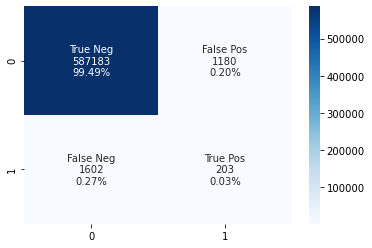

In [15]:
RDbest_matrix_val = confusion_matrix(y_val, RDbest.predict(x_val))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                RDbest_matrix_val.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     RDbest_matrix_val.flatten()/np.sum(RDbest_matrix_val)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RDbest_matrix_val, annot=labels, fmt='', cmap='Blues')

In [16]:
print(metrics.classification_report(y_val, RDbest.predict(x_val)))
print (f1_score(y_val, RDbest.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    588363
           1       0.15      0.11      0.13      1805

    accuracy                           1.00    590168
   macro avg       0.57      0.56      0.56    590168
weighted avg       0.99      1.00      0.99    590168

0.1273525721455458


On obtient un f1-score ( 0.13) qui est beaucoup meilleur que celui avec SMOTE

Decision Tree

# SMOTE et K Nearest Neighbor

In [ ]:
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
pipe.fit(x_train_res, y_train_res)  

In [ ]:
print ('Validation Results')
print (pipe.score(x_val, y_val))
print (recall_score(y_val, pipe.predict(x_val)))
print (f1_score(y_val, pipe.predict(x_val)))
print ('\nTest Results')
print (pipe.score(test_features, test_target))
print (recall_score(test_target, pipe.predict(test_features)))
print (f1_score(test_target, pipe.predict(test_features)))

# Decision Tree

In [53]:
pipelineDT = make_pipeline(StandardScaler(), DecisionTreeClassifier())

In [65]:
paramsDT = {"decisiontreeclassifier__max_depth": [3,6,9,12, None],
              "decisiontreeclassifier__min_samples_leaf": np.arange(1,9,1),
              "decisiontreeclassifier__criterion": ["gini", "entropy"]}
#params = {'decisiontreeclassifier__max_depth': [3, None]}

In [63]:
sorted(pipeline_steps.get_params().keys())

['decisiontreeclassifier',
 'decisiontreeclassifier__ccp_alpha',
 'decisiontreeclassifier__class_weight',
 'decisiontreeclassifier__criterion',
 'decisiontreeclassifier__max_depth',
 'decisiontreeclassifier__max_features',
 'decisiontreeclassifier__max_leaf_nodes',
 'decisiontreeclassifier__min_impurity_decrease',
 'decisiontreeclassifier__min_impurity_split',
 'decisiontreeclassifier__min_samples_leaf',
 'decisiontreeclassifier__min_samples_split',
 'decisiontreeclassifier__min_weight_fraction_leaf',
 'decisiontreeclassifier__presort',
 'decisiontreeclassifier__random_state',
 'decisiontreeclassifier__splitter',
 'memory',
 'standardscaler',
 'standardscaler__copy',
 'standardscaler__with_mean',
 'standardscaler__with_std',
 'steps',
 'verbose']

In [67]:
gridsearchDT = GridSearchCV(estimator=pipelineDT,
                       param_grid=paramsDT,
                       n_jobs=-1,
                       scoring='f1_micro')
gridsearchDT.fit(x_train_res, y_train_res)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [3, 6, 9, 12,
                                                               None],
                         'decisiontreeclassifier__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8])},
             scoring='f1_micro')

In [69]:
print ('Validation Results')
print (gridsearch.score(x_val, y_val))
print (recall_score(y_val, gridsearch.predict(x_val)))
print (f1_score(y_val, gridsearch.predict(x_val)))
print ('\nTest Results')
print (gridsearch.score(test_features, test_target))
print (recall_score(test_target, gridsearch.predict(test_features)))
print (f1_score(test_target, gridsearch.predict(test_features)))

Validation Results
0.983316614929986
0.10803324099722991
0.03810082063305979

Test Results
0.9845159629443142
0.09707602339181287
0.03900375939849624


# Analyse discriminante linéaire

Nous avons décidé de présenter les résultats de l’analyse discriminante linéaire. En effet c’est un modèle relativement simple à mettre en œuvre dont les résultats sont faciles à interpréter. De même, le temps de calcul est plutôt rapide quel que soit la taille des données et est plutôt stable sur des petits échantillons. Pour appliquer cette méthode, deux hyper-paramètres peuvent être utilisés le « solver » et le «shrinkage». Le premier permet de changer la méthode de calcul et le second permet une régularisation lorsque la dimensionnalité augmente.

Création de pipeline

In [144]:
pipelineADL = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())

On obtient une liste des paramètres qu'on peut tenter dans le gridsearch

In [143]:
sorted(pipelineADL.get_params().keys())

['lineardiscriminantanalysis',
 'lineardiscriminantanalysis__n_components',
 'lineardiscriminantanalysis__priors',
 'lineardiscriminantanalysis__shrinkage',
 'lineardiscriminantanalysis__solver',
 'lineardiscriminantanalysis__store_covariance',
 'lineardiscriminantanalysis__tol',
 'memory',
 'standardscaler',
 'standardscaler__copy',
 'standardscaler__with_mean',
 'standardscaler__with_std',
 'steps',
 'verbose']

In [107]:
paramsADL = {'lineardiscriminantanalysis__solver':['svd', 'lsqr','eigen'],
             'lineardiscriminantanalysis__shrinkage':[None, 'auto'],
             'lineardiscriminantanalysis__tol':[0.0001,0.0002,0.0003]} #Paramètres à tester

In [178]:
startADL = time()
#instanciation - recherche des hyperparametres optimaux
gridsearchADL = GridSearchCV(estimator=pipelineADL,
                       param_grid=paramsADL,
                       n_jobs=-1,
                       scoring='f1_micro')
gridsearchADL.fit(x_train_res, y_train_res)
doneADL = time()

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [109]:
tpsADL = round(doneADL - startADL,3)
print(tpsADL/60)

3.86825


Donc le temps de calcul est environ 3,8 minutes  

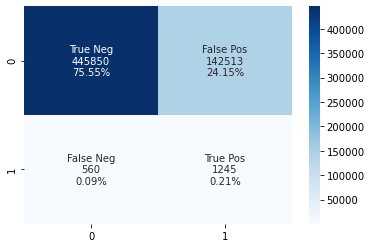

In [142]:
ADL_matrix_val = confusion_matrix(y_val, gridsearchADL.predict(x_val))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                ADL_matrix_val.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     ADL_matrix_val.flatten()/np.sum(ADL_matrix_val)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(ADL_matrix_val, annot=labels, fmt='', cmap='Blues')

Les métriques d'evaluation

In [115]:
print ('Validation Results')
indiceADL=metrics.classification_report(y_val, gridsearchADL.predict(x_val))
indice=report_to_df(indiceADL)
print(indiceADL)

Validation Results
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    588363
           1       0.01      0.69      0.02      1805

    accuracy                           0.76    590168
   macro avg       0.50      0.72      0.44    590168
weighted avg       1.00      0.76      0.86    590168



In [122]:
ADLbest=gridsearchADL.best_estimator_

In [119]:
print('Best Penalty:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__shrinkage'])
print('Best C:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__tol'])
print('Best solver:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__solver'])

Best Penalty: None
Best C: 0.0001
Best solver: svd


On peut voir que le F1 s'arrete à 0.02

### ADL x Random Forest ( Ensemble modeling )

In [146]:
VotingPredictorAR = VotingClassifier(estimators =
                           [('ADL', ADLbest), 
                            ('RD', RDbest)],
                           voting='soft', n_jobs = 4)
VotingPredictorAR = VotingPredictorAR.fit(x_train, y_train)

In [149]:
print ('Validation Results')
indiceAR=metrics.classification_report(y_val, VotingPredictorAR .predict(x_val))
indiceAR=report_to_df(indiceAR)
print(indiceAR)
print(f1_score(y_val, VotingPredictorAR .predict(x_val)))

Validation Results
  Class Name Précision Sensiblité    F1 Fréquence
0          0      1.00       1.00  1.00    588363
1          1      0.09       0.13  0.11      1805
0.1050055617352614


### SVM

In [ ]:
#Test
from sklearn.svm import SVC
pipeSVM = make_pipeline(StandardScaler(), SVC(gamma='auto'))
pipeSVM.fit(x_train_res, y_train_res) 

print ('Validation Results')
#print (clf_rf.score(x_val, y_val))
#print (recall_score(y_val, pipeSVM.predict(x_val)))
print (f1_score(y_val, pipeSVM.predict(x_val)))
#print ('\nTest Results')
#print (clf_rf.score(test_features, test_target))
#print (recall_score(test_target, pipeSVM.predict(test_features)))
print (f1_score(test_target, pipeSVM.predict(test_features)))

#ref: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [ ]:
#bagging svm
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
bagging = make_pipeline(StandardScaler(), BaggingClassifier(SVC(), max_samples=0.5, max_features=0.5))
bagging.fit(x_train_res, y_train_res)
print ('Validation Results')
print (f1_score(y_val, bagging.predict(x_val)))

### xgboost 

In [29]:
#xgboost

# avec cross_val_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
startboost = time()

xg_clas = make_pipeline(StandardScaler(),xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5,  alpha = 10, n_estimators = 10))

#preds = xg_clas.predict(x_val)
tscv = TimeSeriesSplit(n_splits=5)
results = cross_val_score(xg_clas,x_train_res,y_train_res, cv=tscv, scoring='f1_micro')
print ('Validation croisé')
print("resultat validation croisé:", results)
print("f1 mesure: %.2f%% " % (results.mean()*100))

xg_clas.fit(x_train_res,y_train_res)
print ('Validation Results')
print (f1_score(y_val, xg_clas.predict(x_val)))

doneboost = time()
tpsADL = round(doneboost - startboost,3)
print(tpsADL/60)

###Resultat###

#Validation croisé
#resultat validation croisé: [0.99740509 0.99714298 0.00784369 0.40749203 0.63242978]
#f1 mesure: 60.85% 
#resultat validation : 0.01957109040189375

C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation croisé
resultat validation croisé: [0.99740509 0.99714298 0.00784369 0.40749203 0.63242978]
f1 mesure: 60.85% 


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation Results
0.01957109040189375
1.0860333333333334


In [28]:
# avec gridschearchcv
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
startboost = time()
params = {
        'gamma': [0.5, 1, 2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
tscv = TimeSeriesSplit(n_splits=5)
model  = xgb.XGBClassifier(objective = 'binary:logistic')

best_boost = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring="f1",
        n_jobs=None,
        cv=tscv
    )

best_boost.fit(x_train_res,y_train_res)
print ("f1 mesure: %.2f%% " % (f1_score(y_val, xg_clas.predict(x_val))))
print('meilleur paramètres :',best_boost.best_params_)
print('meilleur paramètres :',best_boost.best_score_)
doneboost = time()

tpsADL = round(doneboost - startboost,3)
print(tpsADL/60)

SyntaxError: invalid syntax (<ipython-input-28-564bae6c8dec>, line 7)

In [ ]:
#xgboost sans SMOTE
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
# define model
model = xgb.XGBClassifier(scale_pos_weight=estimate)
# evaluate model
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X, y, scoring='f1', cv=tscv, n_jobs=-1)
# summarize performance
print('Mean f1: %.5f' % mean(scores))

### LGBM 

In [ ]:
#LGBM
import lightgbm as lgb
lgb_classifier = lgb.LGBMClassifier(boosting_type='goss',  
                                    max_depth=5, 
                                    learning_rate=0.1,
                                    n_estimators=1000, 
                                    subsample=0.8,  
                                    colsample_bytree=0.6,
                                   scale_pos_weight = Number_of_negatives/Number_of_positives)
classifier = lgb_classifier.fit(x_train, y_train, verbose=0) 
y_pred = classifier.predict(x_val)
print ('f1 mesure : ',f1_score(y_val, y_pred))

## Conclusion

# Exporter and save 

In [121]:
  #%notebook '/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/ProjetFraud/BIG DATA.ipynb'